# Cleaning Text using Dask

* Cleans text for special characters and removes stopwords

In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client

In [3]:
! pip install nltk
! pip install spacy
! pip install dask
! pip install graphviz

In [4]:
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 9.8 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import dask
import pickle
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk
import pandas as pd
import spacy
import time
import graphviz

# NOTE: stopwords include pronouns! TODO: make custom stop words list?
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Create a cluster where each worker has 1 cores and 4 GiB of memory:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 1,
                      worker_memory = "4GiB"
                      )

# Scale cluster out to 8 such workers:
cluster.scale(8)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.27.130:36809
distributed.scheduler - INFO -   dashboard at:                    :40327
distributed.scheduler - INFO - Receive client connection: Client-3225a258-c5b3-11eb-8b6f-0a4f5d52e9a9
distributed.core - INFO - Starting established connection


In [51]:
client

Client Scheduler: tcp://172.31.27.130:36809 Dashboard: /proxy/40327/status,Cluster Workers: 5 Cores: 5 Memory: 20.00 GiB


In [135]:
# text cleaning adatped from: https://github.com/xssChauhan/Blog-Posts/blob/master/dask-text-processing/Dask%20Text%20Processing.ipynb

import string
import unicodedata
import re

def clean_comments(comment):
    '''
    '''
    new_word_lst = []
    words_lst = comment.split()
    for word in words_lst:
        delete_dict = {sp_character: '' for sp_character in string.punctuation}
        delete_dict[' '] = ''
        table = str.maketrans(delete_dict)
        word = word.translate(table)
        new_word_lst.append(word)
        
    comment = new_word_lst
    comment = [word.lower() for word in comment]
    comment = ' '.join(comment)
#   comment = unicodedata.normalize('NFKD', comment).encode('ascii', 'ignore').decode('ascii') # I dont know if this is working, and we have to remove links


    return comment

from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
keep_stop = set(['she', 'her', 'hers', 'herself'])
mod_stop_words = stop_words - keep_stop


def remove_stopwords(comment):
    '''
    '''
    comment = comment.split()
    no_stop_words = [word for word in comment if word not in mod_stop_words]        
    no_stop_words = ' '.join(no_stop_words)
    return no_stop_words

import spacy

nlp = spacy.load('en_core_web_sm')

def lemmatize(comment, nlp = nlp):
    '''
    '''
    
    word_join = nlp(comment)
    lemmatized = [word.lemma_ for word in word_join]
    
    return lemmatized

def clean_text(df):

    df["cleaned_text"] = df['comment'].map(clean_comments).map(remove_stopwords)
    
    return df
        
            

In [149]:
comments_corpus = pickle.load(open("comments_corpus_final.pickle","rb"))

In [150]:
import dask.dataframe as ddf

# change corpus to dataframe
subreddit_lst = []
comment_lst = []
time_lst = []
for key in comments_corpus:
    for comment, time in comments_corpus[key]:
        subreddit_lst.append(key)
        comment_lst.append(comment)
        time_lst.append(time)
        
comments_df = pd.DataFrame(list(zip(subreddit_lst, comment_lst, time_lst)),
                           columns = ['subreddit', 'comment', 'time created'])
comments_df['cleaned_text'] = ''

#convert to dask dataframe
dask_dataframe = ddf.from_pandas(comments_df, npartitions=6)

In [151]:
dask_dataframe.compute()

,subreddit,comment,time created,cleaned_text
0,TheRedPill,Why the fuck would you be friends with an ex?,1451606442,
1,TheRedPill,Great story full of RP truths. Thanks. Conside...,1451606479,
2,TheRedPill,Lets suss this out. \n\nFor one; she's either ...,1451606497,
3,TheRedPill,Sounds like you may need some more treatment f...,1451606532,
4,TheRedPill,"hack her phone or fb, its the only way you'll ...",1451606539,
...,...,...,...,...
574679,technews,PLEASE! I GET LIKE 3Mb/s I NEEEED THIS,1483147728,
574680,technews,Took some screenshots if it gets removed avail...,1483189543,
574681,technews,[removed],1483199435,
574682,technews,"This is the best tl;dr I could make, [original...",1483205392,


In [152]:
result = dask_dataframe.map_partitions(clean_text, meta=dask_dataframe)

In [153]:
cleaned_df = result.compute()

,subreddit,comment,time created,cleaned_text
0,TheRedPill,Why the fuck would you be friends with an ex?,1451606442,fuck would friends ex
1,TheRedPill,Great story full of RP truths. Thanks. Conside...,1451606479,great story full rp truths thanks consider mak...
2,TheRedPill,Lets suss this out. \n\nFor one; she's either ...,1451606497,lets suss one shes either got high paying job ...
3,TheRedPill,Sounds like you may need some more treatment f...,1451606532,sounds like may need treatment anxiety crucial...
4,TheRedPill,"hack her phone or fb, its the only way you'll ...",1451606539,hack her phone fb way youll truly know think h...
...,...,...,...,...
574679,technews,PLEASE! I GET LIKE 3Mb/s I NEEEED THIS,1483147728,please get like 3mbs neeeed
574680,technews,Took some screenshots if it gets removed avail...,1483189543,took screenshots gets removed available httpii...
574681,technews,[removed],1483199435,removed
574682,technews,"This is the best tl;dr I could make, [original...",1483205392,best tldr could make originalhttpwwwreuterscom...


In [159]:
with open('reddit_full_cleaned.pickle', 'wb') as handle:
    a = pickle.dump(cleaned_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reddit_full_cleaned.pickle', 'rb') as handle:
    b = pickle.load(handle)
print(a == b)


Dask DataFrame Structure:
              subreddit comment time created cleaned_text
npartitions=6                                            
0                  bool    bool         bool         bool
95781               ...     ...          ...          ...
...                 ...     ...          ...          ...
478905              ...     ...          ...          ...
574683              ...     ...          ...          ...
Dask Name: eq, 18 tasks


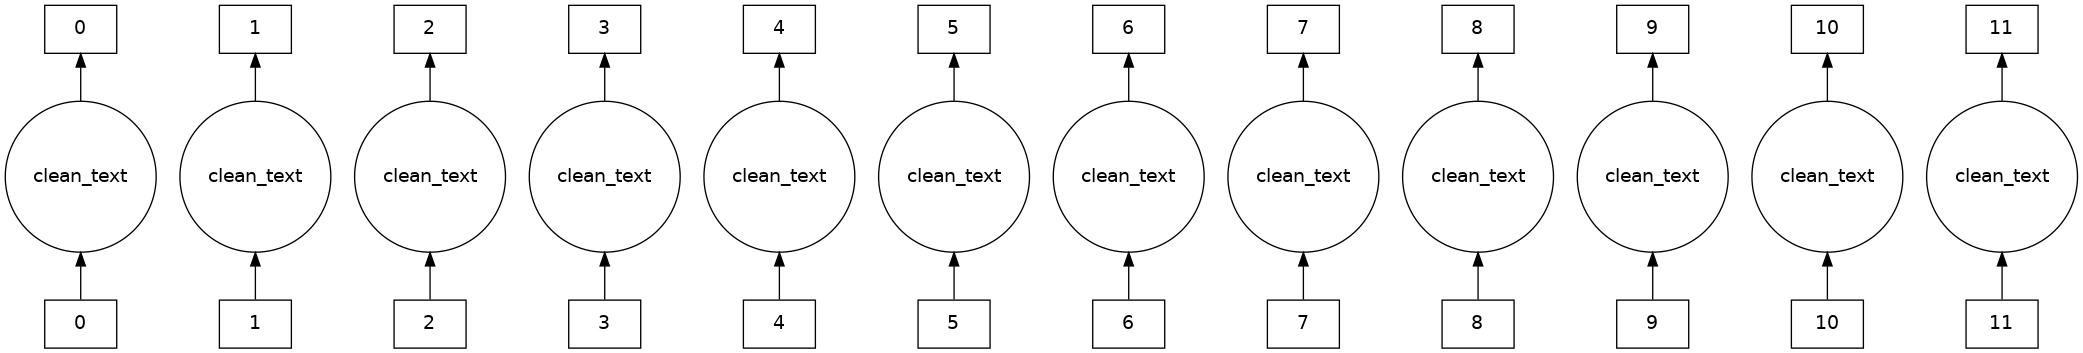

In [141]:
result.visualize()